In [1]:
import sys
sys.path.append("../")
from utils import transform_image_to_kspace, transform_kspace_to_image
import numpy as np
import random
import matplotlib.pyplot as plt
import cv2
import pydicom

#data_path = r'C:\from SSD\fastMRI_brain_DICOM\100099070170\279.dcm'
data_path = r'C:\Users\simon\anaconda3\envs\drs\drs\Data\fastMRI_brain_DICOM\100099070170\308.dcm'
data = pydicom.dcmread(data_path)

image = data.pixel_array
if (np.shape(image) != (320, 320)):
    image = cv2.resize(image, (320, 320))

image = (image - np.mean(image)) / np.std(image)

kspace = transform_image_to_kspace(image)

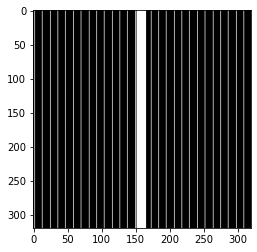

In [2]:
def cartesian_mask(factor, orientation, distribution):
    acceleration, center_fraction = factor
    mask = np.zeros(kspace.shape, dtype=bool)
    num_cols = kspace.shape[0]
    num_low_frequencies = round(num_cols * center_fraction)
       
    if (distribution == "uniform"):
        adjusted_accel = (acceleration * (num_low_frequencies - num_cols)) / (num_low_frequencies * acceleration - num_cols)
        offset = np.random.randint(0, round(adjusted_accel)) # Should it be adjusted_accel - 1 ?
        accel_samples = np.arange(offset, num_cols - 1, adjusted_accel)
        accel_samples = np.around(accel_samples).astype(np.uint)
    elif (distribution == "random"):
        prob = (num_cols / acceleration - num_low_frequencies) / (num_cols - num_low_frequencies)
        accel_samples = np.random.uniform(size=num_cols) < prob
    
    if (orientation == "horizontal"):
        mask[:, round((num_cols - num_low_frequencies - 2) / 2):round((num_cols + num_low_frequencies - 2) / 2)] = True
        mask[:, accel_samples] = True
    elif (orientation == "vertical"):
        mask[int((num_cols - num_low_frequencies - 2) / 2):int((num_cols + num_low_frequencies - 2) / 2), :] = True
        mask[accel_samples,:] = True
 
    return mask

mask = cartesian_mask(random.choice([(2, 0.16), (4, 0.08), (8, 0.04)]), random.choice(["horizontal", "vertical"]), random.choice(["uniform"]))
plt.imshow(mask, cmap='gist_gray')

In [3]:
mask = cartesian_mask(random.choice([(2, 0.16), (4, 0.08), (8, 0.04)]), random.choice(["horizontal", "vertical"]), random.choice(["uniform"]))
kspace = np.where(mask, kspace, (0 + 0j))

In [4]:
# still inside function
img = transform_kspace_to_image(kspace)
img = (img - np.mean(img)) / np.std(img)

(-0.5, 319.5, 319.5, -0.5)

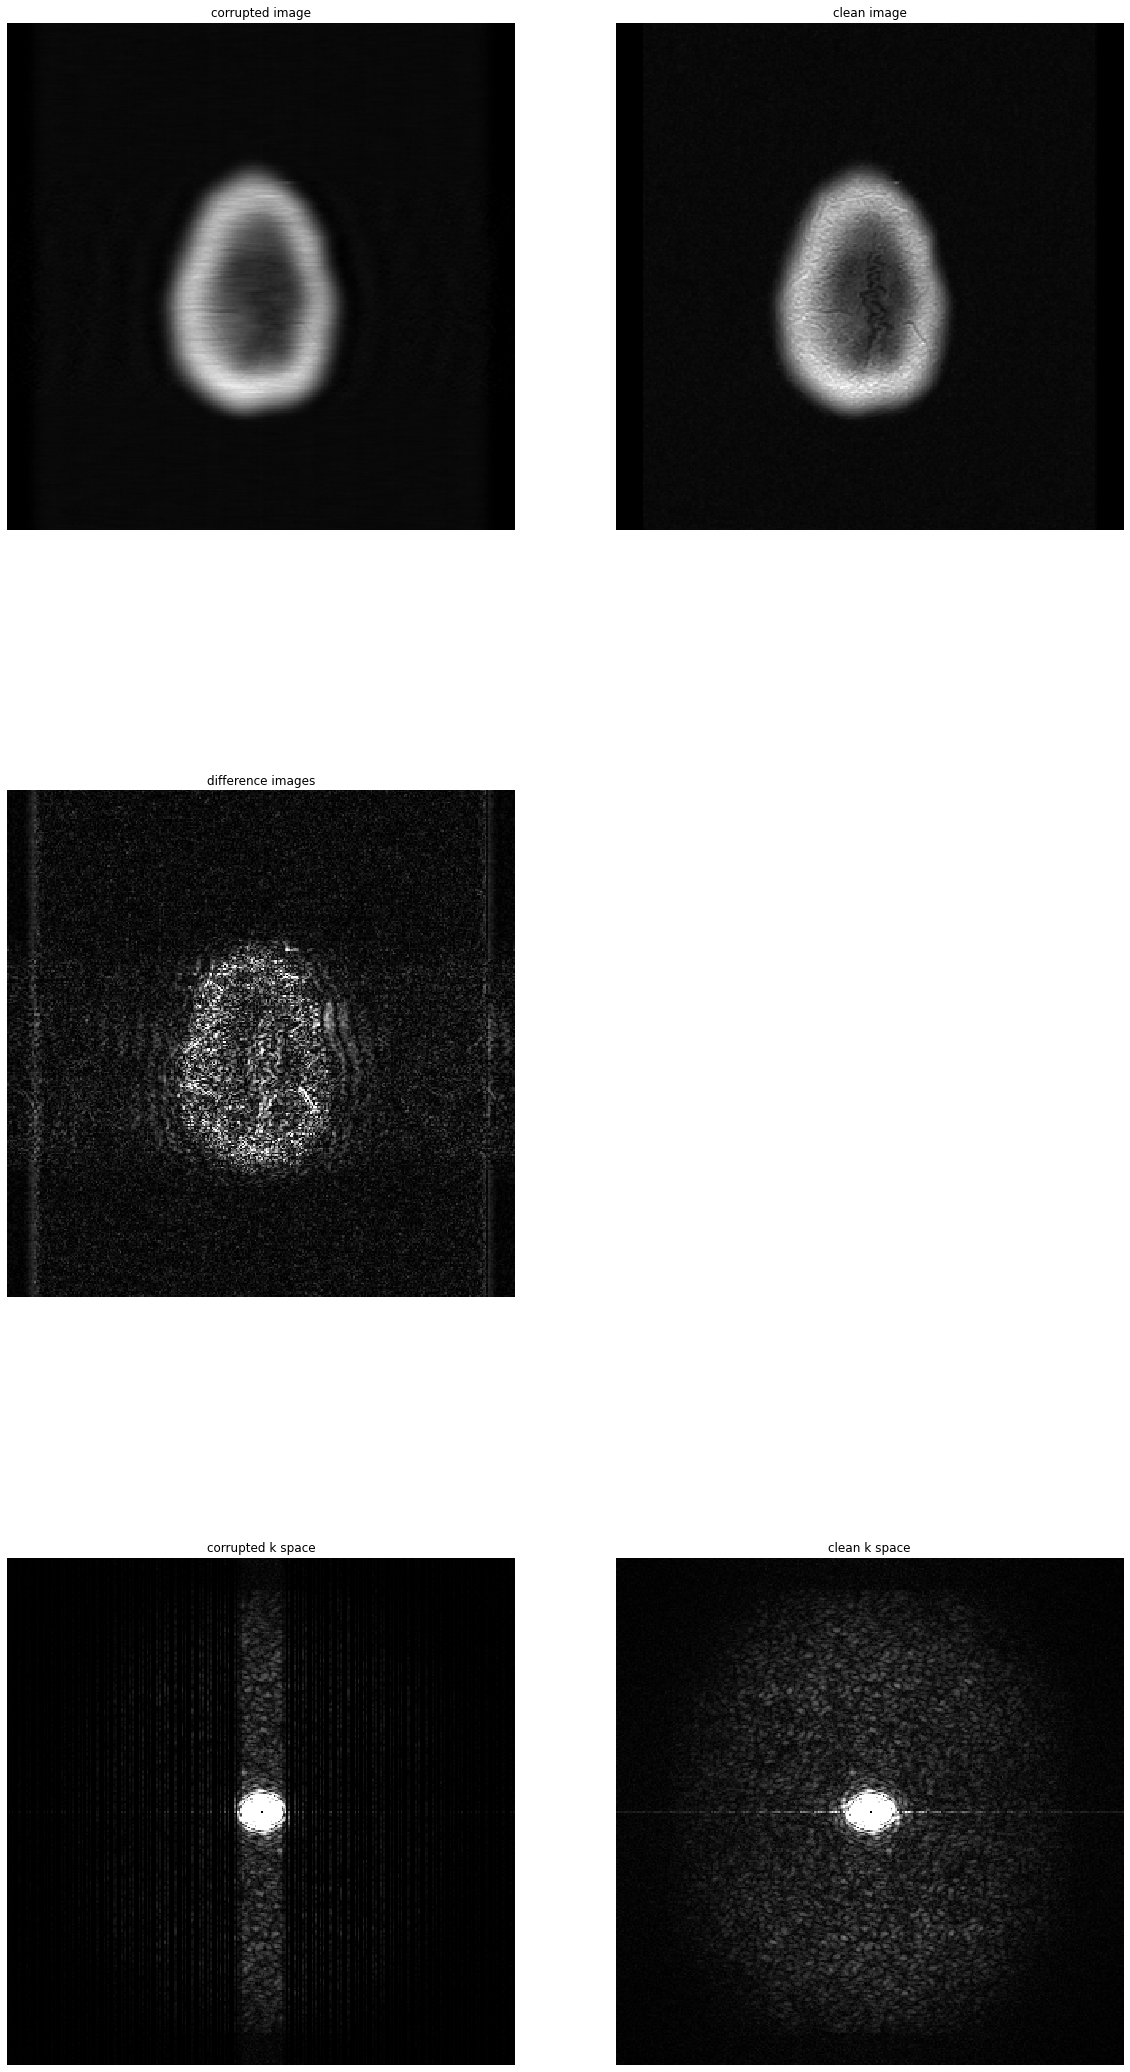

In [5]:
# plotting
hr = image
lr = img

k_lr = np.abs(transform_image_to_kspace(lr))
k_hr = np.abs(transform_image_to_kspace(hr))

k_lr = k_lr / np.max(np.abs(k_lr))
k_hr = k_hr / np.max(np.abs(k_hr))

lr = (lr - np.mean(lr)) / np.std(lr)
hr = (hr - np.mean(hr)) / np.std(hr)

vmx = np.max(hr)
vmn = np.min(hr)
dmx = 0.5
kmx = 0.01

fig = plt.figure(figsize=(20, 40))
ax = fig.add_subplot(3, 2, 1)
ax.imshow(lr, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.set_title("corrupted image")
ax.axis('off')
ax = fig.add_subplot(3, 2, 2)
ax.imshow(hr, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.set_title("clean image")
ax.axis('off')
ax = fig.add_subplot(3, 2, 3)
ax.imshow(np.abs(lr - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.set_title("difference images")
ax.axis('off')
ax = fig.add_subplot(3, 2, 5)
ax.imshow(k_lr, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title("corrupted k space")
ax.axis('off')
ax = fig.add_subplot(3, 2, 6)
ax.imshow(k_hr, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title("clean k space")
ax.axis('off')